In [1]:
import findspark
findspark.init()

import re

import pyspark.sql.types as t
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
from pyspark.sql.window import Window

from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("Spark_Yarn").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-07-21 05:55:09,101 WARN yarn.Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
%%time

df = spark.read.parquet('hdfs://namenode:9000/data/input/*', header=True)
df.printSchema()

root
 |-- client: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- method: string (nullable = true)
 |-- request: string (nullable = true)
 |-- status: string (nullable = true)
 |-- size: string (nullable = true)
 |-- referer: string (nullable = true)
 |-- user_agent: string (nullable = true)

CPU times: user 232 ms, sys: 59.4 ms, total: 291 ms
Wall time: 35.6 s


In [4]:
%%time

df = df.withColumn('client', f.col('client').cast(t.StringType()))
df = df.withColumn('zone', f.split(df.datetime, ' ').getItem(1).cast(t.StringType()))
df = df.withColumn('datetime', f.to_timestamp("datetime", "dd/MMM/yyyy:HH:mm:ss Z").cast(t.TimestampType()))
df = df.withColumn('hour', f.hour(df.datetime))
df = df.withColumn('day', f.dayofmonth(df.datetime))
df = df.withColumn('method', f.col('method').cast(t.StringType()))
df = df.withColumn('status', f.col('status').cast(t.IntegerType()))
df = df.withColumn('size', f.col('size').cast(t.IntegerType()))
df = df.withColumn('referer', f.col('referer').cast(t.StringType()))
df = df.withColumn('user_agent', f.col('user_agent').cast(t.StringType()))
df = df.drop('userid')
df.show(5)

+-------------+-------------------+------+--------------------+------+-----+--------------------+--------------------+-----+----+---+
|       client|           datetime|method|             request|status| size|             referer|          user_agent| zone|hour|day|
+-------------+-------------------+------+--------------------+------+-----+--------------------+--------------------+-----+----+---+
|104.222.32.91|2019-01-26 14:22:19|  POST|/orderAdministrat...|   200|12077|https://www.zanbi...|Mozilla/5.0 (Wind...|+0330|  14| 26|
| 204.18.24.97|2019-01-26 14:22:19|   GET|/image/33811?name...|   200| 2379|https://torob.com...|Mozilla/5.0 (iPho...|+0330|  14| 26|
| 204.18.24.97|2019-01-26 14:22:19|   GET|/image/8878?name=...|   200| 2161|https://torob.com...|Mozilla/5.0 (iPho...|+0330|  14| 26|
| 204.18.24.97|2019-01-26 14:22:19|   GET|/image/33938?name...|   200| 2225|https://torob.com...|Mozilla/5.0 (iPho...|+0330|  14| 26|
| 204.18.24.97|2019-01-26 14:22:19|   GET|/image/33936?name...

In [5]:
df.printSchema()

root
 |-- client: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- method: string (nullable = true)
 |-- request: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- size: integer (nullable = true)
 |-- referer: string (nullable = true)
 |-- user_agent: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)



In [6]:
%%time

df.select(f.countDistinct('client').alias("Số lượng người dùng")).show()

+-------------------+
|Số lượng người dùng|
+-------------------+
|             258445|
+-------------------+

CPU times: user 20.8 ms, sys: 8.94 ms, total: 29.7 ms
Wall time: 25.2 s


In [7]:
%%time

df.groupBy('zone').count().orderBy('zone').show()

+-----+--------+
| zone|   count|
+-----+--------+
|+0330|10364865|
+-----+--------+

CPU times: user 6.21 ms, sys: 25.8 ms, total: 32 ms
Wall time: 14.2 s


In [16]:
df.groupBy('day').agg(f.count('*').alias('count')).agg(f.avg('count').alias('avg')).show()

+---------+
|      avg|
+---------+
|2072973.0|
+---------+



In [17]:
df.groupBy('hour').agg(f.count('*').alias('count')).agg(f.avg('count').alias('avg')).show()

+----------+
|       avg|
+----------+
|431869.375|
+----------+



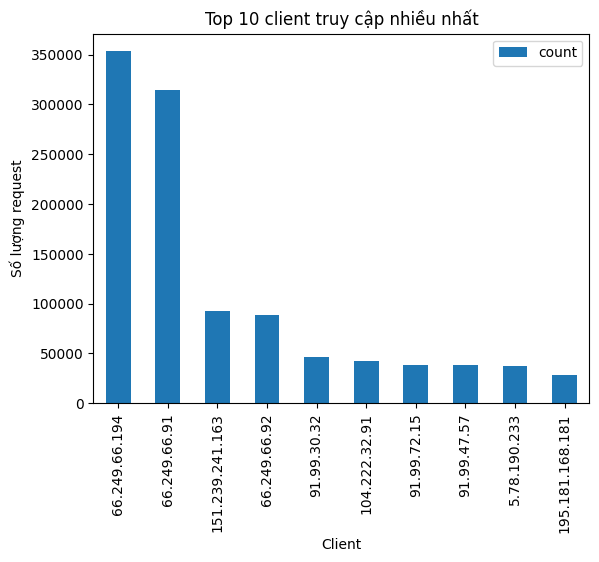

CPU times: user 2.36 s, sys: 1.29 s, total: 3.64 s
Wall time: 1min 3s


In [8]:
%%time

mostUser = df.groupBy('client').count().orderBy(f.col('count').desc()).limit(10).toPandas()
ax = mostUser.plot.bar(x='client', y='count', rot=90)
ax.set_title('Top 10 client truy cập nhiều nhất')
ax.set_xlabel('Client')
ax.set_ylabel('Số lượng request')
plt.show()

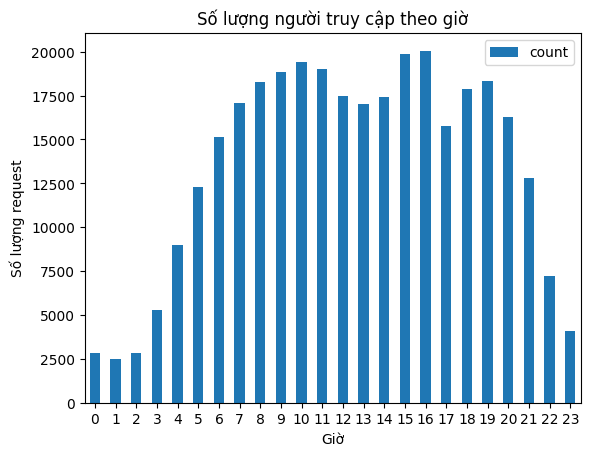

CPU times: user 740 ms, sys: 29.4 ms, total: 769 ms
Wall time: 38.3 s


In [9]:
%%time

userByHour = df.groupBy(['hour']).agg(f.countDistinct('client').alias('count')).orderBy(df.hour.asc()).toPandas()
ax = userByHour.plot.bar(x='hour', y='count', rot=0)
ax.set_title('Số lượng người truy cập theo giờ')
ax.set_xlabel('Giờ')
ax.set_ylabel('Số lượng request')
plt.show()

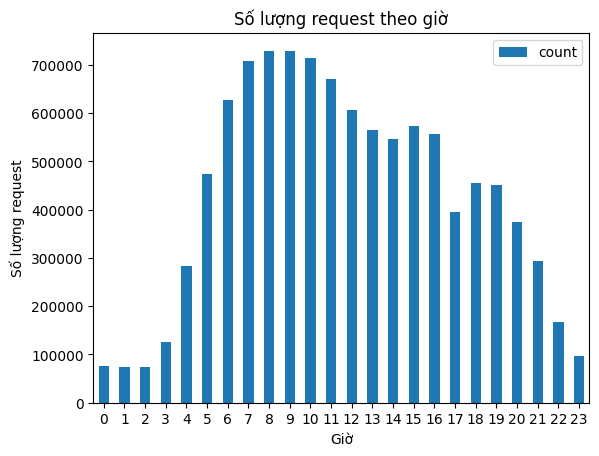

CPU times: user 795 ms, sys: 30.2 ms, total: 826 ms
Wall time: 22.9 s


In [10]:
%%time

userByHour = df.groupBy(['hour']).agg(f.count('*').alias('count')).orderBy(df.hour.asc()).toPandas()
ax = userByHour.plot.bar(x='hour', y='count', rot=0)
ax.set_title('Số lượng request theo giờ')
ax.set_xlabel('Giờ')
ax.set_ylabel('Số lượng request')
plt.show()

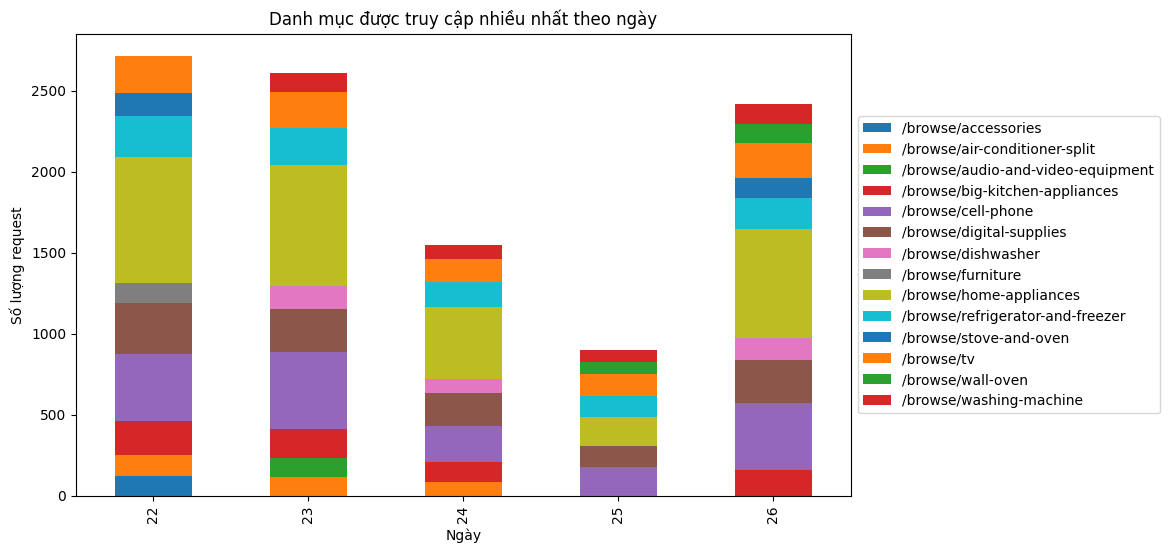

CPU times: user 774 ms, sys: 137 ms, total: 910 ms
Wall time: 13.4 s


In [11]:
%%time

request_counts = df.groupBy(['day', 'request']).count().filter(f.col('request').rlike(r'^/browse/'))
request_counts = request_counts.withColumn('request', f.regexp_extract(f.col('request'), '(^\/browse\/[\w+-]+)', 0))
window_spec = Window.partitionBy(["day"]).orderBy(f.col("count").desc())
top10DF = request_counts.withColumn("rank", f.rank().over(window_spec)).where(f.col("rank") <= 10)
pivot_df = top10DF.toPandas().pivot_table(index='day', columns='request', values='count', aggfunc='mean')

ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Danh mục được truy cập nhiều nhất theo ngày')
ax.set_xlabel('Ngày')
ax.set_ylabel('Số lượng request')
plt.show()

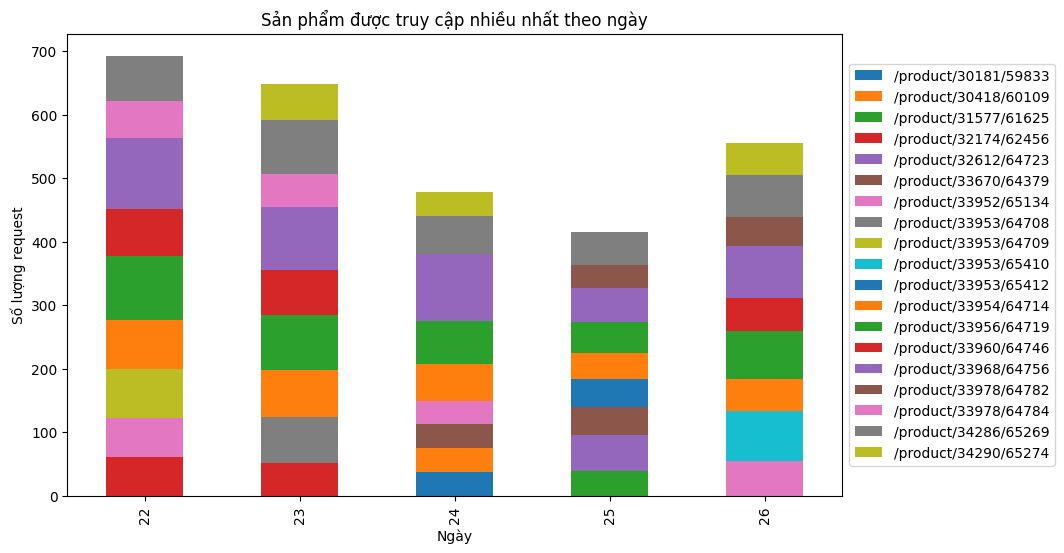

CPU times: user 1.25 s, sys: 104 ms, total: 1.36 s
Wall time: 12.3 s


In [12]:
%%time

request_counts = df.groupBy(['day', 'request']).count().filter(f.col('request').rlike(r'^\/product\/\d+\/\d+'))
request_counts = request_counts.withColumn('request', f.regexp_extract(f.col('request'), '(^\/product\/\d+\/\d+)', 0))
window_spec = Window.partitionBy(["day"]).orderBy(f.col("count").desc())
top10DF = request_counts.withColumn("rank", f.rank().over(window_spec)).where(f.col("rank") <= 10)
pivot_df = top10DF.toPandas().pivot_table(index='day', columns='request', values='count', aggfunc='mean')

ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title('Sản phẩm được truy cập nhiều nhất theo ngày')
ax.set_xlabel('Ngày')
ax.set_ylabel('Số lượng request')
plt.show()

+--------------------------------+------+
|referer                         |count |
+--------------------------------+------+
|torob.com                       |124958|
|www.google.com                  |107476|
|emalls.ir                       |8371  |
|api.torob.com                   |6041  |
|www-zanbil-ir.cdn.ampproject.org|5994  |
|ptcnovin.com                    |4160  |
|www.garda.ir                    |1879  |
|www.samsungcenter.ir            |1456  |
|www.angabin.ir                  |1367  |
|irantradeco.ir                  |1196  |
+--------------------------------+------+



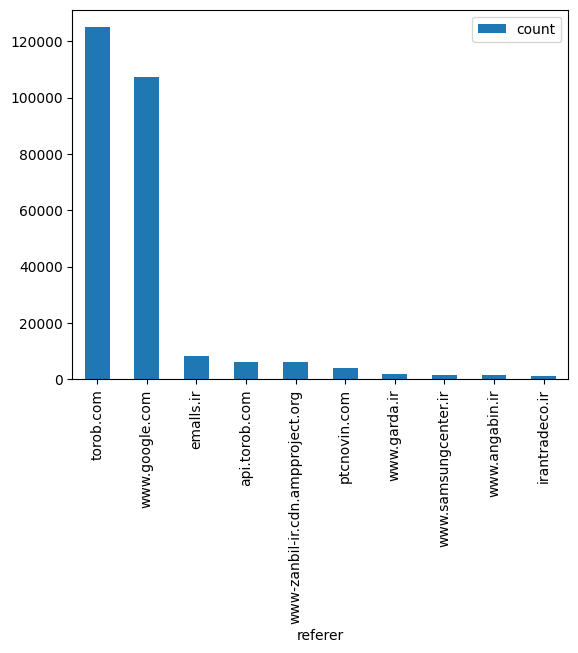

In [13]:
pd_df = df.filter(~f.col('referer').like('%zanbil.ir%'))\
        .filter(~f.col('referer').like('%znbl.ir%'))\
        .filter(~f.col('referer').like('-'))\
        .groupBy('referer').count()
pd_df = pd_df.withColumn('referer', f.regexp_extract(f.col('referer'), '(\/\/)([\w+\.-]+\.\w+)(\/)', 2))
pd_df = pd_df.filter(~f.col('referer').like('')).groupBy('referer').agg(f.sum('count').alias('count')).orderBy(f.col('count').desc()).limit(10)

pd_df.show(10, truncate=False)

pd_df = pd_df.toPandas().plot.bar(x='referer', y='count')
plt.show()